In [1]:
import os
from os import path
import sys
import contextlib
import argparse
import string
import numpy as np
from numpy import fft
import pandas as pd
from yahoo_fin import stock_info as si
import matplotlib.pyplot as plt
import pylab as pl
from datetime import datetime

In [2]:
import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

In [33]:
# Set the desired stock ticker symbol
TICKER = 'EPAM'
# Set the number of days ahead to forecast
LOOKUP_STEP = 20
# Set a start and end date for historical analysis
startDate = '1/1/2001'
endDate = '3/15/2022'

In [34]:
def fourierExtrapolation(x, n_predict, period):
    n = x.size
    n_harm = period
    t = np.arange(0, n)
    p = np.polyfit(t, x, 1)
    x_notrend = x - p[0] * t
    x_freqdom = fft.fft(x_notrend)
    f = fft.fftfreq(n)
    indexes = list(range(n))
    indexes.sort(key=lambda i: np.absolute(f[i]))

    t = np.arange(0, n + n_predict)
    restored_sig = np.zeros(t.size)
    for i in indexes[:1 + n_harm * 2]:
        ampli = np.absolute(x_freqdom[i]) / n
        phase = np.angle(x_freqdom[i])
        restored_sig += ampli * np.cos(2 * np.pi * f[i] * t + phase)
    return restored_sig + p[0] * t

In [35]:
# populate a dataframe with historical data
df = si.get_data(TICKER, start_date = startDate, end_date=endDate)

In [36]:
df

,open,high,low,close,adjclose,volume,ticker
2012-02-08,13.750000,15.050000,13.250000,14.000000,14.000000,3336200,EPAM
2012-02-09,14.170000,14.220000,13.750000,13.910000,13.910000,580500,EPAM
2012-02-10,14.000000,14.030000,13.770000,13.960000,13.960000,336300,EPAM
2012-02-13,13.910000,14.420000,13.630000,13.650000,13.650000,175900,EPAM
2012-02-14,13.600000,13.790000,13.300000,13.440000,13.440000,122200,EPAM
...,...,...,...,...,...,...,...
2022-03-08,175.320007,193.720001,168.589996,186.750000,186.750000,3329200,EPAM
2022-03-09,200.479996,200.929993,187.160004,198.410004,198.410004,2247000,EPAM
2022-03-10,195.139999,196.309998,184.509995,188.759995,188.759995,1227100,EPAM
2022-03-11,196.779999,207.839996,189.320007,200.139999,200.139999,1613100,EPAM


In [37]:
# how many cycles are in the data?
# SME's expect a total of 61 cycles in a 7 year period.
# There are 253 trading days in a year
# 253 * 7 / 61 = 29
NPERIOD = int(len(df.index)/29)

In [38]:
hist = df.loc[:,'adjclose'].values
train = df.loc[:endDate,'adjclose'].values

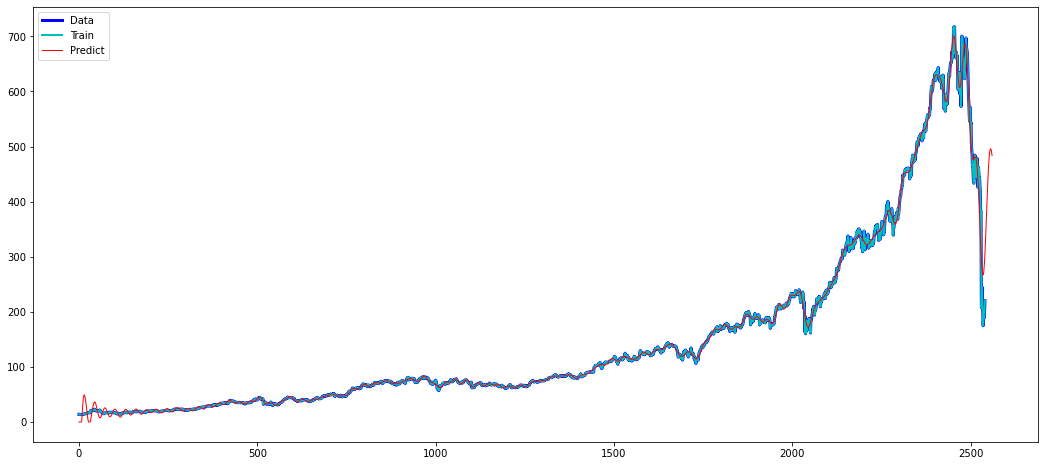

In [39]:
plt.figure(figsize=(18,8))
n_predict = len(hist) - len(train) + LOOKUP_STEP
extrapolation = fourierExtrapolation(train, n_predict, NPERIOD)
extrapolation[extrapolation < 0] = 0
pl.plot(np.arange(0, hist.size), hist, 'b', label = 'Data', linewidth = 3)
pl.plot(np.arange(0, train.size), train, 'c', label = 'Train', linewidth = 2)
pl.plot(np.arange(0, extrapolation.size), extrapolation, 'r', label = 'Predict', linewidth = 1)
pl.legend()

In [40]:
print(f"Future $ price after {LOOKUP_STEP} days is {extrapolation[-1]:.2f}")

Future $ price after 20 days is 483.76


In [41]:
print(f"Expected percent change is %{(extrapolation[-1]/df['adjclose'][-1]-1)*100:.2f}")

Expected percent change is %119.89
